In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

import pymysql
import pymysql.cursors

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


# LOAD MODEL
### 모델 불러오기

In [2]:
from keras.models import model_from_json
json_file = open("/Users/jill/Desktop/model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/Users/jill/Desktop/model.h5")
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


In [3]:
column_name = ['timestamp',
#                'accident',
                 'voltage',
                  'frequency']


tt = pd.read_csv('/Users/jill/Desktop/SINSIHEUNG_0702.csv', 'r', delimiter=',', header = None,
                                                            names = column_name)

# tt = branch_trip(b1)
migeum = tt
tt.head(10)

,timestamp,voltage,frequency
0,2019-07-01 21:41:35.0000000Z,1.023172,-0.000093
1,2019-07-01 21:41:35.0166667Z,1.022989,-0.000093
2,2019-07-01 21:41:35.0333333Z,1.022695,-0.000095
3,2019-07-01 21:41:35.0500000Z,1.022517,-0.000098
4,2019-07-01 21:41:35.0666667Z,1.022576,-0.000102
5,2019-07-01 21:41:35.0833333Z,1.022809,-0.000105
6,2019-07-01 21:41:35.1000000Z,1.023056,-0.000105
7,2019-07-01 21:41:35.1166667Z,1.023183,-0.000103
8,2019-07-01 21:41:35.1333333Z,1.023167,-0.000102
9,2019-07-01 21:41:35.1500000Z,1.023018,-0.000103


In [4]:
def create_predictions(tt, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 2
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(tt) - time_steps, step):
        xs = tt['voltage'].values[i: i + time_steps]
        ys = tt['frequency'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(tt[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [5]:
pd.options.mode.chained_assignment = None  # default='warn'
# df['voltage'] = df['voltage'] / df['voltage'].max()
# df['frequency'] = df['frequency'] / df['frequency'].max()
tt['voltage'] = tt['voltage'] / 1.21 
tt['frequency'] = tt['frequency'] / 0.01
# Round numbers
tt = tt.round({'voltage': 4, 'frequency': 4})
tt.tail(5)

,timestamp,voltage,frequency
995,2019-07-01 21:41:49.9833429Z,0.8463,0.0013
996,2019-07-01 21:41:49.9833430Z,0.8463,0.0013
997,2019-07-01 21:41:49.9833431Z,0.8463,0.0013
998,2019-07-01 21:41:49.9833432Z,0.8463,0.0013
999,2019-07-01 21:41:49.9833433Z,0.8463,0.0013


In [6]:
TIME_PERIODS = 1000
input_shape = 2000

N_FEATURES = 2

segments = []
xs = tt['voltage'].values[:TIME_PERIODS]
ys = tt['frequency'].values[:TIME_PERIODS]
# Retrieve the most often used label in this segment
segments.append([xs, ys])

# Bring the segments into a better shape
xx_test = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_PERIODS, N_FEATURES)

xx_test = xx_test.reshape(xx_test.shape[0], input_shape)

xx_test = xx_test.astype('float32')

xx_test

array([[0.8456, 0.8454, 0.8452, ..., 0.0013, 0.0013, 0.0013]],
      dtype=float32)

In [7]:
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values

le.fit_transform(['branch_trip',
            'line_fault',
            'shunt_loss',
            'gen_loss',
            'load_loss',
            'vref'])

array([0, 2, 4, 1, 3, 5])

In [8]:
print(list(le.classes_))

['branch_trip', 'gen_loss', 'line_fault', 'load_loss', 'shunt_loss', 'vref']


In [9]:
test_record = xx_test[0].reshape(1,input_shape)
predict = np.argmax(loaded_model.predict(test_record), axis = 1)
# print()
print(predict[0])
print(le.inverse_transform(predict)[0])
print(xx_test.shape)

0
branch_trip
(1, 2000)


Text(0,0.5,'frequency')

<Figure size 432x288 with 0 Axes>

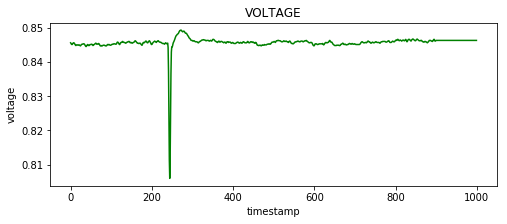

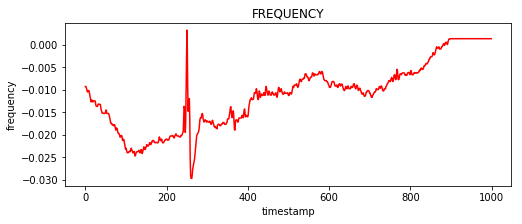

In [10]:
plt.figure(1)
plt.subplots(figsize=(8, 3))
plt.plot(tt['voltage'][:1000], 'g')
plt.title('VOLTAGE')
plt.xlabel('timestamp')
plt.ylabel('voltage')

plt.figure(2)
plt.subplots(figsize=(8, 3))
plt.plot(tt['frequency'][:1000], 'r')
plt.title('FREQUENCY')
plt.xlabel('timestamp')
plt.ylabel('frequency')